In [1]:
import csv
import pandas as pd
import math
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import random
import seaborn as sns
import openpyxl
import os

In [ ]:
os.makedirs('./INPUT',exist_ok=True)
os.makedirs('./OUTPUT',exist_ok=True)

In [17]:
now = datetime.now().strftime('%Y_%m_%d__%H_%M')
now

'2023_07_09__20_54'

# 1. 전처리
- 1-1. 부산, 울산 train, test 합치기
- 1-2. 힘, 방향에 맞는 정규화 및 표준화 처리

# 2. 분류모델
- 2-1. distinction 원 핫 인코딩 및 필요없는 컬럼 제거 
- 2-2. PCA 
- 2-3. 하이퍼파라미터 튜닝, 모델 학습, 결과 확인
- 2-4. 이상치 제거
- 2-5. xlsx파일 불러와서 예측값 concat

--------------------
- 'RF': (RandomForestClassifier()), # 랜덤포레스트
- 'ET': (ExtraTreesClassifier()), # 엑스트라트리
- 'BAG' : (BaggingClassifier()), # 배깅
- 'GRA' : (GradientBoostingClassifier()), # 그레디언트부스팅
- 'XGB': (XGBClassifier()), # 엑스지부스트
- 'LGBM': (LGBMClassifier()), # 라이트그레디언트부스팅

In [2]:
#busan_train 데이터
#81691 rows × 20 columns
busan_train = pd.read_csv('busan_train_final.csv')

In [3]:
busan_train

,target,distinction,num,time_M,latitude,longitude,wd,ws,max_wh,sog,cog,hdg,mon,hour,flow_ws,flow_wd,m_distance,distance,velocity,max_distance
0,0,N3,1,2021-01-14 22:47:00,35.049747,129.072122,358.0,1.2,0.5,0.500000,123.800000,144.025042,1.0,22.0,21.3,98.0,0.110526,0.000000,0.000000,0.000000
1,0,N3,1,2021-01-14 22:50:00,35.049485,129.072438,185.0,0.2,0.5,0.200000,131.700000,144.025042,1.0,22.0,24.7,47.0,0.092704,42.517905,14.172635,0.040941
2,0,N3,1,2021-01-14 22:56:00,35.049452,129.072440,284.0,0.1,0.5,0.200000,255.900000,144.025042,1.0,22.0,19.6,92.0,0.094425,3.674664,0.612444,0.043749
3,0,N3,1,2021-01-14 23:02:00,35.049402,129.072257,311.0,0.9,0.4,0.100000,280.300000,144.025042,1.0,23.0,23.4,100.0,0.111588,18.777934,3.129656,0.040283
4,0,N3,1,2021-01-14 23:11:00,35.049100,129.072215,264.0,1.7,0.4,0.100000,157.600000,144.025042,1.0,23.0,20.7,90.0,0.134343,33.832279,3.759142,0.072440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81686,1,N3,87,2022-05-07 20:22:00,35.052328,129.061033,36.0,10.8,1.9,0.700000,150.333333,66.333333,5.0,20.0,33.5,267.0,0.435814,47.279572,47.279572,0.533990
81687,1,N3,87,2022-05-07 20:23:00,35.052317,129.061133,35.0,10.4,1.9,0.500000,38.000000,52.000000,5.0,20.0,30.6,265.0,0.429974,9.825080,9.825080,0.528105
81688,1,N3,87,2022-05-07 20:24:00,35.052605,129.061183,46.0,11.0,1.9,1.200000,6.000000,60.666667,5.0,20.0,30.6,260.0,0.415921,32.437295,32.437295,0.503336
81689,1,N3,87,2022-05-07 20:25:00,35.052993,129.061288,32.0,11.4,1.9,1.371429,19.000000,87.714286,5.0,20.0,16.2,218.0,0.386950,44.290654,44.290654,0.469697


In [4]:
busan_train['distinction'].unique()

array(['N3', 'N5', 'N4', 'N1', 'N2', 'M7', 'M8-9'], dtype=object)

In [5]:
#busan_test 데이터
#67678 rows × 19 columns
busan_test = pd.read_csv('busan_test_final.csv').iloc[:,1:]

In [6]:
busan_test

,num,distinction,time_M,latitude,longitude,wd,ws,max_wh,sog,cog,hdg,mon,hour,flow_ws,flow_wd,m_distance,distance,velocity,max_distance
0,1001,N3,2022-08-14 00:55:00,35.052636,129.041104,229.0,6.7,0.4,1.420000,59.640000,208.00,8.0,0.0,40.0,70.0,0.059309,0.000000,0.000000,0.000000
1,1001,N3,2022-08-14 00:56:00,35.052971,129.041714,228.0,6.2,0.4,1.820000,56.000000,215.00,8.0,0.0,23.8,65.0,0.008093,70.375880,70.375880,0.066884
2,1001,N3,2022-08-14 00:57:00,35.053145,129.042158,224.0,6.7,0.4,0.933333,72.533333,221.00,8.0,0.0,16.3,51.0,0.062511,47.564725,47.564725,0.111442
3,1001,N3,2022-08-14 00:58:00,35.053170,129.042352,227.0,6.1,0.4,0.833333,78.300000,225.00,8.0,0.0,13.8,43.0,0.081513,19.167910,19.167910,0.128199
4,1001,N3,2022-08-14 01:07:00,35.053220,129.042730,223.0,5.3,0.3,0.100000,29.200000,233.00,8.0,1.0,23.0,63.0,0.118475,37.362040,4.151338,0.161636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67673,1116,N5,2023-03-08 10:58:00,35.022233,129.065683,230.0,5.9,0.6,0.500000,225.000000,235.00,3.0,10.0,36.9,109.0,0.167888,65.489763,21.829921,0.286127
67674,1116,N5,2023-03-08 10:59:00,35.022033,129.065571,230.0,5.6,0.6,0.400000,197.250000,228.50,3.0,10.0,35.9,112.0,0.185919,24.820577,24.820577,0.307497
67675,1116,N5,2023-03-08 11:00:00,35.021871,129.065579,229.0,6.2,0.6,0.400000,177.000000,224.50,3.0,11.0,75.9,57.0,0.196264,18.114443,18.114443,0.318914
67676,1116,N5,2023-03-08 11:01:00,35.021745,129.065617,229.0,6.2,0.6,0.400000,161.666667,221.00,3.0,11.0,37.5,106.0,0.206381,14.511386,14.511386,0.326852


In [7]:
busan_test['distinction'].unique()

array(['N3', 'N4', 'N5', 'N1', 'N2', 'M8-9', 'M7'], dtype=object)

In [8]:
#ulsan_train 데이터
#134680 rows × 20 columns
ulsan_train = pd.read_csv('ulsan_train_final.csv')
ulsan_train

,target,distinction,time_M,num,latitude,longitude,wd,ws,max_wh,sog,cog,hdg,mon,hour,flow_ws,flow_wd,m_distance,distance,velocity,max_distance
0,0,E2,2021-02-14 14:37:00,1,35.433247,129.458993,172.0,2.0,0.8,0.200,48.600000,203.4,2.0,14.0,14.8,122.0,0.098456,0.000000,0.000000,0.000000
1,0,E2,2021-02-14 14:38:00,1,35.433300,129.459056,176.0,1.7,0.8,0.200,38.166667,202.0,2.0,14.0,11.6,93.0,0.092438,7.403619,7.403619,0.008180
2,0,E2,2021-02-14 14:39:00,1,35.433337,129.459100,166.0,1.6,0.8,0.275,32.250000,202.0,2.0,14.0,7.1,2.0,0.088216,5.215083,5.215083,0.013960
3,0,E2,2021-02-14 14:41:00,1,35.433517,129.459200,162.0,1.1,0.8,0.300,11.000000,205.0,2.0,14.0,12.4,44.0,0.082234,21.217525,10.608762,0.035417
4,0,E2,2021-02-14 14:44:00,1,35.433883,129.459233,158.0,1.2,0.8,0.500,346.000000,206.0,2.0,14.0,9.7,51.0,0.101255,40.765064,13.588355,0.074019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134675,1,E1,2022-06-24 06:33:00,163,35.444952,129.415232,229.0,12.0,2.3,0.100,227.100000,207.0,6.0,6.0,41.6,64.0,0.371770,4.558282,1.519427,0.620865
134676,1,E1,2022-06-24 06:39:00,163,35.444370,129.414865,234.0,11.8,2.3,0.700,178.900000,192.0,6.0,6.0,36.3,51.0,0.300694,69.659794,11.609966,0.549203
134677,1,E1,2022-06-24 06:42:00,163,35.444025,129.414896,238.0,11.9,2.3,0.300,157.200000,192.0,6.0,6.0,45.6,69.0,0.265702,38.422735,12.807578,0.513416
134678,1,E1,2022-06-24 06:43:00,163,35.443916,129.414923,239.0,11.6,2.3,0.600,171.500000,193.5,6.0,6.0,39.7,59.0,0.261126,12.310037,12.310037,0.502676


In [9]:
ulsan_train['distinction'].unique()

array(['E2', 'E1', 'M', 'E3'], dtype=object)

In [14]:
#ulsan_test 데이터
#51137 rows × 19 columns
ulsan_test = pd.read_csv('ulsan_test_final.csv').iloc[:,1:]

In [20]:
ulsan_test['distinction'].unique()

array(['E1', 'E3', 'E2', 'M'], dtype=object)

# 1. 전처리

# 단, 합칠때, 
## busan, ulsan의 train피처 동일한지 확인하기!
## busan, ulsan의 test피처 동일한지 확인하기
## train, test 피처 동일한지 확인하기!

In [21]:
print(busan_train.columns.unique())
print(ulsan_train.columns.unique())
print(busan_test.columns.unique())
print(ulsan_test.columns.unique())

Index(['target', 'distinction', 'num', 'time_M', 'latitude', 'longitude', 'wd',
       'ws', 'max_wh', 'sog', 'cog', 'hdg', 'mon', 'hour', 'flow_ws',
       'flow_wd', 'm_distance', 'distance', 'velocity', 'max_distance'],
      dtype='object')
Index(['target', 'distinction', 'time_M', 'num', 'latitude', 'longitude', 'wd',
       'ws', 'max_wh', 'sog', 'cog', 'hdg', 'mon', 'hour', 'flow_ws',
       'flow_wd', 'm_distance', 'distance', 'velocity', 'max_distance'],
      dtype='object')
Index(['num', 'distinction', 'time_M', 'latitude', 'longitude', 'wd', 'ws',
       'max_wh', 'sog', 'cog', 'hdg', 'mon', 'hour', 'flow_ws', 'flow_wd',
       'm_distance', 'distance', 'velocity', 'max_distance'],
      dtype='object')
Index(['num', 'distinction', 'time_M', 'latitude', 'longitude', 'wd', 'ws',
       'max_wh', 'sog', 'cog', 'hdg', 'mon', 'hour', 'flow_ws', 'flow_wd',
       'm_distance', 'distance', 'velocity', 'max_distance'],
      dtype='object')


### 1-1-1. busan_train, ulsan_train 합치기

In [258]:
bs_us_train1 = pd.concat([busan_train,ulsan_train]).reset_index(drop=True)

In [259]:
bs_us_train1

,target,distinction,num,time_M,latitude,longitude,wd,ws,max_wh,sog,cog,hdg,mon,hour,flow_ws,flow_wd,m_distance,distance,velocity,max_distance
0,0,N3,1,2021-01-14 22:47:00,35.049747,129.072122,358.0,1.2,0.5,0.50,123.80,144.025042,1.0,22.0,21.3,98.0,0.110526,0.000000,0.000000,0.000000
1,0,N3,1,2021-01-14 22:50:00,35.049485,129.072438,185.0,0.2,0.5,0.20,131.70,144.025042,1.0,22.0,24.7,47.0,0.092704,42.517905,14.172635,0.040941
2,0,N3,1,2021-01-14 22:56:00,35.049452,129.072440,284.0,0.1,0.5,0.20,255.90,144.025042,1.0,22.0,19.6,92.0,0.094425,3.674664,0.612444,0.043749
3,0,N3,1,2021-01-14 23:02:00,35.049402,129.072257,311.0,0.9,0.4,0.10,280.30,144.025042,1.0,23.0,23.4,100.0,0.111588,18.777934,3.129656,0.040283
4,0,N3,1,2021-01-14 23:11:00,35.049100,129.072215,264.0,1.7,0.4,0.10,157.60,144.025042,1.0,23.0,20.7,90.0,0.134343,33.832279,3.759142,0.072440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216366,1,E1,163,2022-06-24 06:33:00,35.444952,129.415232,229.0,12.0,2.3,0.10,227.10,207.000000,6.0,6.0,41.6,64.0,0.371770,4.558282,1.519427,0.620865
216367,1,E1,163,2022-06-24 06:39:00,35.444370,129.414865,234.0,11.8,2.3,0.70,178.90,192.000000,6.0,6.0,36.3,51.0,0.300694,69.659794,11.609966,0.549203
216368,1,E1,163,2022-06-24 06:42:00,35.444025,129.414896,238.0,11.9,2.3,0.30,157.20,192.000000,6.0,6.0,45.6,69.0,0.265702,38.422735,12.807578,0.513416
216369,1,E1,163,2022-06-24 06:43:00,35.443916,129.414923,239.0,11.6,2.3,0.60,171.50,193.500000,6.0,6.0,39.7,59.0,0.261126,12.310037,12.310037,0.502676


In [24]:
bs_us_train1['target'].value_counts()

0    211197
1      5174
Name: target, dtype: int64

### 1-1-2. busan_test, ulsan_test 합치기

In [260]:
bs_us_test1 = pd.concat([busan_test,ulsan_test]).reset_index(drop=True)

In [273]:
bs_us_test1.longitude.max()

129.49776

In [ ]:
column_list = ['num','distinction','latitude','longitude','wd','ws','max_wh','sog','cog','hdg','mon','hour','flow_ws',
               'flow_wd','m_distance','distance','velocity']

In [ ]:
for i in column_list:
    sns.histplot(data=bs_us_train1, x=i, hue="target")
    plt.show()

In [211]:
bs_us_train1.corr()

,target,num,latitude,longitude,wd,ws,max_wh,sog,cog,hdg,mon,hour,flow_ws,flow_wd,m_distance,distance,velocity,max_distance
target,1.000000,-0.004897,0.004201,0.006185,-0.029559,0.223378,0.208509,0.057579,-0.008089,-0.027619,-0.019768,-0.028278,0.018022,0.004292,0.080776,0.280371,0.269303,0.056985
num,-0.004897,1.000000,0.412545,0.425983,0.181818,0.104591,-0.127548,-0.014074,0.025695,0.132940,0.149296,-0.014249,0.243515,-0.040458,-0.052865,-0.030594,-0.076867,-0.040912
latitude,0.004201,0.412545,1.000000,0.988287,0.078811,0.232086,0.171108,-0.008850,0.023290,-0.039363,0.039386,-0.011190,0.121962,-0.032015,-0.049215,0.000075,-0.066005,-0.022081
longitude,0.006185,0.425983,0.988287,1.000000,0.082251,0.242623,0.168059,-0.006485,0.029498,-0.030697,0.045948,-0.013273,0.123725,-0.036190,-0.011356,0.032517,-0.037391,0.015326
wd,-0.029559,0.181818,0.078811,0.082251,1.000000,-0.203483,-0.299452,-0.004148,-0.030347,0.430739,0.005263,-0.094829,0.064028,-0.057151,0.002118,-0.071763,-0.079280,0.025468
ws,0.223378,0.104591,0.232086,0.242623,-0.203483,1.000000,0.440627,0.056639,0.003279,-0.137980,-0.030894,0.015054,0.022691,-0.048761,0.070288,0.301217,0.245828,0.111852
max_wh,0.208509,-0.127548,0.171108,0.168059,-0.299452,0.440627,1.000000,0.062545,0.001392,-0.311646,-0.094101,0.007068,-0.039009,0.070541,0.104882,0.252998,0.267030,0.124632
sog,0.057579,-0.014074,-0.008850,-0.006485,-0.004148,0.056639,0.062545,1.000000,-0.007499,-0.006745,-0.010202,0.005432,-0.008055,0.016305,0.064633,0.116713,0.155230,0.072948
cog,-0.008089,0.025695,0.023290,0.029498,-0.030347,0.003279,0.001392,-0.007499,1.000000,-0.011039,-0.001501,-0.015975,0.000777,-0.010173,-0.017567,0.007956,0.000013,-0.011336
hdg,-0.027619,0.132940,-0.039363,-0.030697,0.430739,-0.137980,-0.311646,-0.006745,-0.011039,1.000000,0.000257,-0.036510,0.046389,-0.123786,0.002421,-0.059990,-0.065592,0.004379


## 1-2. 힘, 방향에 맞는 표준화

### 1-2-1. 힘 피처 표준화(ws, max_wh, sog,flow_ws,m_distance, distance, velocity)

In [27]:
bs_us_train1.columns

Index(['target', 'distinction', 'num', 'time_M', 'latitude', 'longitude', 'wd',
       'ws', 'max_wh', 'sog', 'cog', 'hdg', 'mon', 'hour', 'flow_ws',
       'flow_wd', 'm_distance', 'distance', 'velocity', 'max_distance'],
      dtype='object')

In [28]:
bs_us_train1['ws'] = bs_us_train1.groupby('distinction')['ws'].transform(lambda x: (x - x.mean()) / x.std())
bs_us_train1['max_wh'] = bs_us_train1.groupby('distinction')['max_wh'].transform(lambda x: (x - x.mean()) / x.std())
bs_us_train1['sog'] = bs_us_train1.groupby('distinction')['sog'].transform(lambda x: (x - x.mean()) / x.std())
bs_us_train1['m_distance'] = bs_us_train1.groupby('num')['m_distance'].transform(lambda x: (x - x.mean()) / x.std())
bs_us_train1['velocity'] = bs_us_train1.groupby('distinction')['velocity'].transform(lambda x: (x - x.mean()) / x.std())
bs_us_train1['flow_ws'] = bs_us_train1.groupby('distinction')['flow_ws'].transform(lambda x: (x - x.mean()) / x.std())

In [29]:
bs_us_test1['ws'] = bs_us_test1.groupby('distinction')['ws'].transform(lambda x: (x - x.mean()) / x.std())
bs_us_test1['max_wh'] = bs_us_test1.groupby('distinction')['max_wh'].transform(lambda x: (x - x.mean()) / x.std())
bs_us_test1['sog'] = bs_us_test1.groupby('distinction')['sog'].transform(lambda x: (x - x.mean()) / x.std())
bs_us_test1['m_distance'] = bs_us_test1.groupby('num')['m_distance'].transform(lambda x: (x - x.mean()) / x.std())
bs_us_test1['velocity'] = bs_us_test1.groupby('distinction')['velocity'].transform(lambda x: (x - x.mean()) / x.std())
bs_us_test1['flow_ws'] = bs_us_test1.groupby('distinction')['flow_ws'].transform(lambda x: (x - x.mean()) / x.std())

### 1-2-2. 방향 피처 정규화(wd, cog, hdg,flow_wd) -> sin, cos

In [30]:
def direction_feature(df,feature_names):
    for feature_name in feature_names:
        #각도 변환
        df[feature_name] = df[feature_name].apply(np.deg2rad)
        
        #sin, cos 계산
        df[f'sin_{feature_name}'] = np.sin(df[feature_name])
        df[f'cos_{feature_name}'] = np.cos(df[feature_name])
    
    return df

In [31]:
bs_us_train1 = direction_feature(bs_us_train1, ['wd','cog','hdg','flow_wd'])

In [32]:
bs_us_test1 = direction_feature(bs_us_test1, ['wd','cog','hdg','flow_wd'])

In [33]:
bs_us_train1.columns

Index(['target', 'distinction', 'num', 'time_M', 'latitude', 'longitude', 'wd',
       'ws', 'max_wh', 'sog', 'cog', 'hdg', 'mon', 'hour', 'flow_ws',
       'flow_wd', 'm_distance', 'distance', 'velocity', 'max_distance',
       'sin_wd', 'cos_wd', 'sin_cog', 'cos_cog', 'sin_hdg', 'cos_hdg',
       'sin_flow_wd', 'cos_flow_wd'],
      dtype='object')

In [34]:
bs_us_test1.columns

Index(['num', 'distinction', 'time_M', 'latitude', 'longitude', 'wd', 'ws',
       'max_wh', 'sog', 'cog', 'hdg', 'mon', 'hour', 'flow_ws', 'flow_wd',
       'm_distance', 'distance', 'velocity', 'max_distance', 'sin_wd',
       'cos_wd', 'sin_cog', 'cos_cog', 'sin_hdg', 'cos_hdg', 'sin_flow_wd',
       'cos_flow_wd'],
      dtype='object')

# 2. 분류모델
- 2-1. distinction 원 핫 인코딩 및 필요없는 컬럼 제거 
- 2-2. PCA 
- 2-3. 하이퍼파라미터 튜닝, 모델 학습, 결과 확인
- 2-4. 이상치 제거
- 2-5. xlsx파일 불러와서 예측값 concat

### 2-1. distinction 원 핫 인코딩 및 필요없는 컬럼 제거

In [38]:
# 범주를 나타내는 숫자들 원핫인코딩
bs_us_train1 = pd.get_dummies(bs_us_train1, columns=[distinction'])
bs_us_train1

,target,num,time_M,latitude,longitude,wd,ws,max_wh,sog,cog,...,distinction_E2,distinction_E3,distinction_M,distinction_M7,distinction_M8-9,distinction_N1,distinction_N2,distinction_N3,distinction_N4,distinction_N5
0,0,1,2021-01-14 22:47:00,35.049747,129.072122,6.248279,-1.219863,-0.708670,0.067313,2.160718,...,0,0,0,0,0,0,0,1,0,0
1,0,1,2021-01-14 22:50:00,35.049485,129.072438,3.228859,-1.531966,-0.708670,-0.025380,2.298599,...,0,0,0,0,0,0,0,1,0,0
2,0,1,2021-01-14 22:56:00,35.049452,129.072440,4.956735,-1.563176,-0.708670,-0.025380,4.466298,...,0,0,0,0,0,0,0,1,0,0
3,0,1,2021-01-14 23:02:00,35.049402,129.072257,5.427974,-1.313494,-0.855682,-0.056278,4.892158,...,0,0,0,0,0,0,0,1,0,0
4,0,1,2021-01-14 23:11:00,35.049100,129.072215,4.607669,-1.063812,-0.855682,-0.056278,2.750639,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216366,1,163,2022-06-24 06:33:00,35.444952,129.415232,3.996804,1.178175,1.909890,-0.102543,3.963643,...,0,0,0,0,0,0,0,0,0,0
216367,1,163,2022-06-24 06:39:00,35.444370,129.414865,4.084070,1.131803,1.909890,0.296714,3.122394,...,0,0,0,0,0,0,0,0,0,0
216368,1,163,2022-06-24 06:42:00,35.444025,129.414896,4.153884,1.154989,1.909890,0.030543,2.743658,...,0,0,0,0,0,0,0,0,0,0
216369,1,163,2022-06-24 06:43:00,35.443916,129.414923,4.171337,1.085432,1.909890,0.230171,2.993240,...,0,0,0,0,0,0,0,0,0,0


In [39]:
bs_us_train1.columns

Index(['target', 'num', 'time_M', 'latitude', 'longitude', 'wd', 'ws',
       'max_wh', 'sog', 'cog', 'hdg', 'flow_ws', 'flow_wd', 'm_distance',
       'distance', 'velocity', 'max_distance', 'sin_wd', 'cos_wd', 'sin_cog',
       'cos_cog', 'sin_hdg', 'cos_hdg', 'sin_flow_wd', 'cos_flow_wd', 'mon_1',
       'mon_2', 'mon_3', 'mon_4', 'hour_0', 'hour_1', 'distinction_E1',
       'distinction_E2', 'distinction_E3', 'distinction_M', 'distinction_M7',
       'distinction_M8-9', 'distinction_N1', 'distinction_N2',
       'distinction_N3', 'distinction_N4', 'distinction_N5'],
      dtype='object')

In [40]:
#필요없는 열 제거
bs_us_train1.drop(['num','time_M','latitude','longitude','wd','cog','hdg','flow_wd','distance','max_distance','mon','hour'], axis=1,inplace=True)

In [48]:
# 범주를 나타내는 숫자들 원핫인코딩
bs_us_test1 = pd.get_dummies(bs_us_test1, columns=['distinction'])
bs_us_test1

,ws,max_wh,sog,flow_ws,m_distance,distance,velocity,max_distance,sin_wd,cos_wd,...,distinction_E2,distinction_E3,distinction_M,distinction_M7,distinction_M8-9,distinction_N1,distinction_N2,distinction_N3,distinction_N4,distinction_N5
0,0.498106,-0.784876,4.869854,1.140747,-1.067556,-0.733134,-0.673560,-2.231925,-0.754710,-0.656059,...,0,0,0,0,0,0,0,1,0,0
1,0.365550,-0.784876,6.411610,0.172021,-2.190422,3.716238,13.042956,-1.608069,-0.743145,-0.669131,...,0,0,0,0,0,0,0,1,0,0
2,0.498106,-0.784876,2.994051,-0.276463,-0.997359,2.274049,8.596979,-1.192465,-0.694658,-0.719340,...,0,0,0,0,0,0,0,1,0,0
3,0.339038,-0.784876,2.608612,-0.425958,-0.580758,0.478718,3.062336,-1.036162,-0.731354,-0.681998,...,0,0,0,0,0,0,0,1,0,0
4,0.126948,-0.974806,-0.217940,0.124183,0.229614,1.629005,0.135551,-0.724284,-0.681998,-0.731354,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118810,1.560707,-0.194544,-0.224823,-1.050146,0.871043,0.314987,0.187233,-0.267561,-0.438371,0.898794,...,0,0,0,0,0,0,0,0,0,0
118811,1.677405,-0.194544,0.503408,-0.360648,0.255210,0.967137,0.040656,-0.176198,-0.374607,0.927184,...,0,0,0,0,0,0,0,0,0,0
118812,1.881625,-0.194544,-0.224823,-0.812105,0.783658,-0.015013,-0.323290,-0.135951,-0.438371,0.898794,...,0,0,0,0,0,0,0,0,0,0
118813,1.560707,-0.194544,-0.224823,-0.377065,0.072183,0.237975,0.130158,-0.288084,-0.422618,0.906308,...,0,0,0,0,0,0,0,0,0,0


In [49]:
bs_us_test1.columns

Index(['ws', 'max_wh', 'sog', 'flow_ws', 'm_distance', 'distance', 'velocity',
       'max_distance', 'sin_wd', 'cos_wd', 'sin_cog', 'cos_cog', 'sin_hdg',
       'cos_hdg', 'sin_flow_wd', 'cos_flow_wd', 'mon_1', 'mon_2', 'mon_3',
       'mon_4', 'hour_0', 'hour_1', 'distinction_E1', 'distinction_E2',
       'distinction_E3', 'distinction_M', 'distinction_M7', 'distinction_M8-9',
       'distinction_N1', 'distinction_N2', 'distinction_N3', 'distinction_N4',
       'distinction_N5'],
      dtype='object')

In [ ]:
#필요없는 열 제거
bs_us_test1.drop(['num','time_M','latitude','longitude','wd','cog','hdg','flow_wd','distance','max_distance','mon','hour'], axis=1,inplace=True)

In [51]:
len(bs_us_test1.columns)

33

### 2-2. PCA

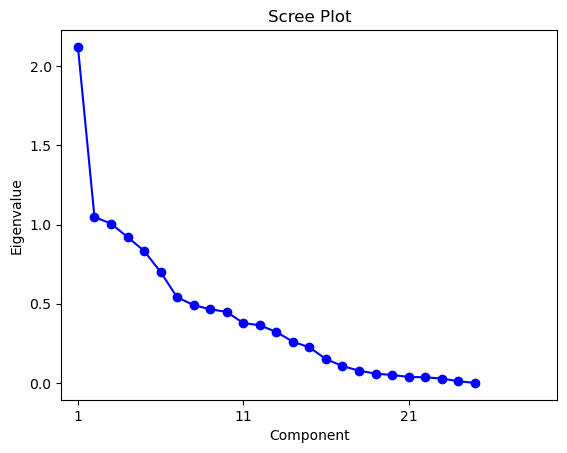

0.9480382339940411


In [138]:
# a = busan_train[[  'ws',
#        'max_wh', 'sog',  'mon',
#         'hour',  'flow_ws',  'm_distance',
#        'distance', 'velocity']].copy()

a = x_train.copy()
# Scree 그림 그리기
pca = PCA()
pca.fit(x_test)

plt.xticks(np.arange(1, len(pca.explained_variance_) + 1, 10))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'bo-')
plt.xlabel('Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.xlim(0, 30)
plt.show()

# 설명력 계산
def explained_variance(X, Y):
    # 원본 데이터의 분산 계산
    var_X = np.var(X, axis=0).sum()
    
    # 주성분으로 투영된 데이터의 분산 계산
    var_Y = np.var(Y, axis=0).sum()
    
    # 설명력 계산
    explained_var = var_Y / var_X
    
    return explained_var

def pca(X, K):
   # 데이터 중앙화
    mu = np.mean(X, axis=0)
    Z = X - mu
    
    # 공분산 행렬 계산
    C = np.cov(X, rowvar=False)
    
    # 공분산 행렬의 고유값 분해
    eigenvalues, eigenvectors = np.linalg.eig(C)
    
    # 주성분 선택
    indices = np.argsort(eigenvalues)[::-1][:K]  # 내림차순으로 정렬된 고유값의 인덱스
    W = eigenvectors[:, indices]
    
    # 주성분으로 데이터 투영
    Y = Z.dot(W)
    
    return Y

# 예시 데이터
Y = pca(x_test, 15)
explained_var = explained_variance(x_test, Y)
print(explained_var)

In [144]:
# 주성분 개수 설정 리스트
x_train
x_test
n_components_list = [7, 10, 13, 15]

for n_components in n_components_list:
    # PCA 객체 생성
    pca = PCA(n_components=n_components)

    # 데이터에 PCA 적용
    principalComponents = pca.fit_transform(x_train)

    # PCA 결과를 데이터프레임으로 변환
    globals()[f'pca_tr_{n_components}'] = pd.DataFrame(data=principalComponents, columns=[f'PC{i}' for i in range(1, n_components + 1)])

for n_components in n_components_list:
    # PCA 객체 생성
    pca = PCA(n_components=n_components)

    # 데이터에 PCA 적용
    principalComponents = pca.fit_transform(x_test)

    # PCA 결과를 데이터프레임으로 변환
    globals()[f'pca_tst_{n_components}'] = pd.DataFrame(data=principalComponents, columns=[f'PC{i}' for i in range(1, n_components + 1)])

### 2-3. 하이퍼파라미터 튜닝, 모델 학습, 결과 확인
#### train-> X, y분할
#### test->X_test로 넣어서 모델 별 y_pred 예측

In [68]:
# ML 분류기
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트
from sklearn.ensemble import ExtraTreesClassifier # 엑스트라트리
from sklearn.ensemble import BaggingClassifier # 배깅
from sklearn.ensemble import GradientBoostingClassifier # 그레디언트부스팅
from xgboost import XGBClassifier # 엑스지부스트
from lightgbm import LGBMClassifier # 라이트그레디언트부스팅

from sklearn import model_selection # 모델 선택
from sklearn import metrics # 평가지표
from sklearn.model_selection import RandomizedSearchCV

In [104]:
# ML 분류기 딕셔너리: 이름, (모델)
CLASS_MAP = {
    'RF': (RandomForestClassifier()), # 랜덤포레스트
    'ET': (ExtraTreesClassifier()), # 엑스트라트리
    'BAG' : (BaggingClassifier()), # 배깅
    'GRA' : (GradientBoostingClassifier()), # 그레디언트부스팅
    'XGB': (XGBClassifier()), # 엑스지부스트
    'LGBM': (LGBMClassifier()), # 라이트그레디언트부스팅
    }

In [66]:
param_grid = {
    'n_estimators': [80, 100, 150, 200], #앙상블에 포함될 트리의 개수
    'max_depth': [3, 5, 10], #각 트리의 최대 깊이
    'min_samples_split': [2, 5, 10], # 노드를 분할하기 위해 필요한 최소 샘플 개수
    'min_samples_leaf': [1, 2, 4], #리프 노드가 되기 위해 필요한 최소 샘플 개수
}

In [56]:
# ROC 곡선 플롯
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [57]:
#CSI 평가지표
def calculate_csi(y_true, y_pred):
    TP = sum((y_true == 1) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))
    FP = sum((y_true == 0) & (y_pred == 1))
    
    print(f'TP : {TP} , FN : {FN} , FP : {FP}')
    CSI = TP / (TP + FN + FP)
    
    return CSI

In [58]:
#데이터를 X와 y로 분할
#train data
x_train = bs_us_train1.drop('target', axis=1)
y_train = bs_us_train1['target']

#test data
x_test = bs_us_test1.copy()

In [ ]:
#column몇개 나오는지 확인해보기
columns = list(x_train.columns)
columns

pca_tr_7,pca_tst_7
pca_tr_10,pca_tst_10
pca_tr_13,pca_tst_13
pca_tr_15,pca_tst_15
x_train,x_test

# 하이퍼파라미터 적용한 train&test

In [155]:
pred_df1 = pd.DataFrame()
#모델별 성능치 비교
def final_evaluate_cl(clf, X, Y, X_test, name, k=None, test_size=0.3, scoring="f1_weighted",feature_names=None):
    
    # 학습 데이터와 검증 데이터로 분할
    X_train, X_valid, Y_train, y_true = model_selection.train_test_split(X, Y, test_size=test_size, shuffle=True, stratify=Y,random_state=42)
    
    if k:
        kf = model_selection.KFold(n_splits=k)
        scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=kf, scoring=scoring)
        print(name + "모델 %d-fold Cross Validation Accuracy(교차검증 정확도): %0.2f"%(k,scores.mean()*100))
        
    #RandomizedSearchCV(모델명, param_distributions=하이퍼 파라미터 조정 범위, n_iter=10, cv=5, scoring=scoring, random_state=42)
    # RandomizedSearchCV를 사용하여 모델의 하이퍼파라미터 튜닝
    random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=5, scoring=scoring, random_state=42)
    random_search.fit(X_train, Y_train)
    
    # 최적의 하이퍼파라미터로 모델 재학습
    best_model = random_search.best_estimator_
    best_model.fit(X_train, Y_train)
    print('최적 하이퍼파라미터: ', random_search.best_params_)
    
    
    # 검증 데이터로 모델 성능 평가
    valid_predictions = best_model.predict(X_valid)
    
    
    # 테스트 데이터로 예측
    y_test_pred = best_model.predict(X_test)
    pred_df1[name] = y_test_pred
    
    
    csi_score = calculate_csi(y_true, valid_predictions)
    print("CSI 평가지표 : %.2f" %(csi_score))

    print("Accuracy Score(정확도 점수): %.2f" % metrics.accuracy_score(y_true, valid_predictions))
    print()

    print("Classification report(분류 보고서)")
    print(metrics.classification_report(y_true, valid_predictions))
    print()

    print("Confussion matrix(혼동행렬)")
    print(metrics.confusion_matrix(y_true, valid_predictions))
    print()
    
    print('AUC(ROC 곡선 아래 면적): %.2f'% metrics.roc_auc_score(y_true, valid_predictions))
    print()
    
    probs = best_model.predict_proba(X_valid) 
    prob = probs[:, 1] #클래스 1에 대한 예측 확률만을 선택. 양성클래스에 속할 확률.
    fper, tper, thresholds = metrics.roc_curve(y_true, prob)
    plot_roc_curve(fper, tper)

    if hasattr(best_model, "feature_importances_"):
        print("Feature importances(특성 중요도)")
        for f, imp in zip(feature_names, best_model.feature_importances_):
            print("%20s: %s" % (f, round(imp * 100, 1)))
        print()

ET모델 5-fold Cross Validation Accuracy(교차검증 정확도): 98.60
최적 하이퍼파라미터:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
TP : 130 , FN : 1422 , FP : 6
CSI 평가지표 : 0.08
Accuracy Score(정확도 점수): 0.98

Classification report(분류 보고서)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     63360
           1       0.96      0.08      0.15      1552

    accuracy                           0.98     64912
   macro avg       0.97      0.54      0.57     64912
weighted avg       0.98      0.98      0.97     64912


Confussion matrix(혼동행렬)
[[63354     6]
 [ 1422   130]]

AUC(ROC 곡선 아래 면적): 0.54



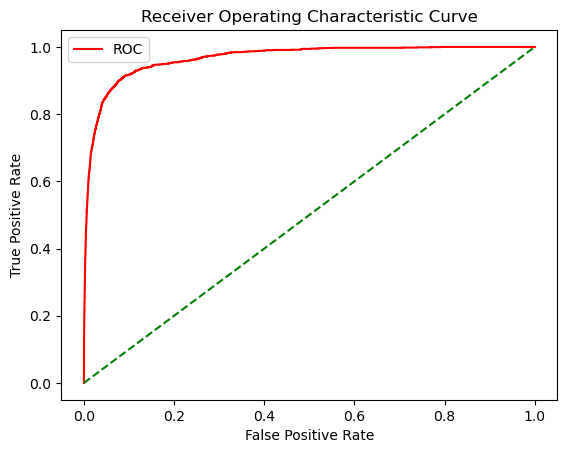

Feature importances(특성 중요도)
                  ws: 15.2
              max_wh: 14.3
                 sog: 4.4
             flow_ws: 1.5
          m_distance: 29.6
            distance: 16.7
            velocity: 2.2
        max_distance: 1.9
              sin_wd: 0.6
              cos_wd: 0.7
             sin_cog: 1.2
             cos_cog: 1.8
             sin_hdg: 1.5
             cos_hdg: 1.4
         sin_flow_wd: 0.7
         cos_flow_wd: 0.8
               mon_1: 0.6
               mon_2: 0.3
               mon_3: 0.4
               mon_4: 0.1
              hour_0: 0.6
              hour_1: 0.6
      distinction_E1: 1.0
      distinction_E2: 1.3
      distinction_E3: 0.8



In [156]:
for name, model in CLASS_MAP.items():
    final_evaluate_cl(model, x_train, y_train, x_test, name, k=5, test_size=0.3, feature_names=columns)

In [158]:
pred_df1.to_csv('pred_df1.csv')

In [191]:
pred_df1['ET'].value_counts()

0    118660
1       155
Name: ET, dtype: int64

# 하이퍼파라미터 적용한  pca

In [162]:
pca_df = pd.DataFrame()

In [161]:
#모델별 성능치 비교
def pca_fi_evaluate_cl(clf, X, Y, X_test, name, k=None, test_size=0.3, scoring="f1_weighted",feature_names=None):
    
    # 학습 데이터와 검증 데이터로 분할
    X_train, X_valid, Y_train, y_true = model_selection.train_test_split(X, Y, test_size=test_size, shuffle=True, stratify=Y,random_state=42)
    
    if k:
        kf = model_selection.KFold(n_splits=k)
        scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=kf, scoring=scoring)
        print(name + "모델 %d-fold Cross Validation Accuracy(교차검증 정확도): %0.2f"%(k,scores.mean()*100))
        
    #RandomizedSearchCV(모델명, param_distributions=하이퍼 파라미터 조정 범위, n_iter=10, cv=5, scoring=scoring, random_state=42)
    # RandomizedSearchCV를 사용하여 모델의 하이퍼파라미터 튜닝
    random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=5, scoring=scoring, random_state=42)
    random_search.fit(X_train, Y_train)
    
    # 최적의 하이퍼파라미터로 모델 재학습
    best_model = random_search.best_estimator_
    best_model.fit(X_train, Y_train)
    print('최적 하이퍼파라미터: ', random_search.best_params_)
    
    
    # 검증 데이터로 모델 성능 평가
    valid_predictions = best_model.predict(X_valid)
    
    
    # 테스트 데이터로 예측
    y_test_pred = best_model.predict(X_test)
    pca_df[name + '_ET'] = y_test_pred
    
    
    csi_score = calculate_csi(y_true, valid_predictions)
    print("CSI 평가지표 : %.2f" %(csi_score))

    print("Accuracy Score(정확도 점수): %.2f" % metrics.accuracy_score(y_true, valid_predictions))
    print()

    print("Classification report(분류 보고서)")
    print(metrics.classification_report(y_true, valid_predictions))
    print()

    print("Confussion matrix(혼동행렬)")
    print(metrics.confusion_matrix(y_true, valid_predictions))
    print()
    
    print('AUC(ROC 곡선 아래 면적): %.2f'% metrics.roc_auc_score(y_true, valid_predictions))
    print()
    
    probs = best_model.predict_proba(X_valid) 
    prob = probs[:, 1] #클래스 1에 대한 예측 확률만을 선택. 양성클래스에 속할 확률.
    fper, tper, thresholds = metrics.roc_curve(y_true, prob)
    plot_roc_curve(fper, tper)

    if hasattr(best_model, "feature_importances_"):
        print("Feature importances(특성 중요도)")
        for f, imp in zip(feature_names, best_model.feature_importances_):
            print("%20s: %s" % (f, round(imp * 100, 1)))
        print()

pca_7모델 5-fold Cross Validation Accuracy(교차검증 정확도): 97.88
최적 하이퍼파라미터:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
TP : 162 , FN : 1390 , FP : 33
CSI 평가지표 : 0.10
Accuracy Score(정확도 점수): 0.98

Classification report(분류 보고서)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     63360
           1       0.83      0.10      0.19      1552

    accuracy                           0.98     64912
   macro avg       0.90      0.55      0.59     64912
weighted avg       0.97      0.98      0.97     64912


Confussion matrix(혼동행렬)
[[63327    33]
 [ 1390   162]]

AUC(ROC 곡선 아래 면적): 0.55



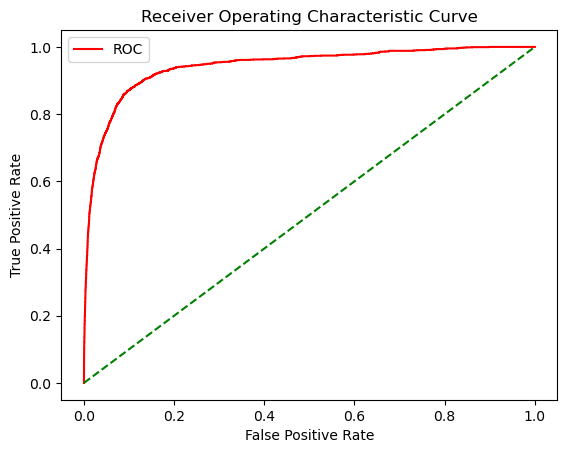

Feature importances(특성 중요도)
                 PC1: 49.0
                 PC2: 17.8
                 PC3: 3.3
                 PC4: 3.4
                 PC5: 18.1
                 PC6: 4.4
                 PC7: 3.9

pca_10모델 5-fold Cross Validation Accuracy(교차검증 정확도): 97.94
최적 하이퍼파라미터:  {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}
TP : 166 , FN : 1386 , FP : 35
CSI 평가지표 : 0.10
Accuracy Score(정확도 점수): 0.98

Classification report(분류 보고서)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     63360
           1       0.83      0.11      0.19      1552

    accuracy                           0.98     64912
   macro avg       0.90      0.55      0.59     64912
weighted avg       0.97      0.98      0.97     64912


Confussion matrix(혼동행렬)
[[63325    35]
 [ 1386   166]]

AUC(ROC 곡선 아래 면적): 0.55



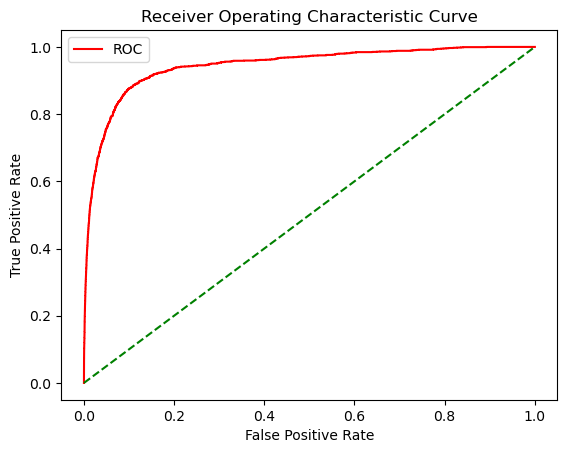

Feature importances(특성 중요도)
                 PC1: 46.5
                 PC2: 17.7
                 PC3: 3.2
                 PC4: 2.8
                 PC5: 16.7
                 PC6: 3.2
                 PC7: 4.3
                 PC8: 2.7
                 PC9: 1.7
                PC10: 1.1

pca_13모델 5-fold Cross Validation Accuracy(교차검증 정확도): 98.03
최적 하이퍼파라미터:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
TP : 126 , FN : 1426 , FP : 19
CSI 평가지표 : 0.08
Accuracy Score(정확도 점수): 0.98

Classification report(분류 보고서)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     63360
           1       0.87      0.08      0.15      1552

    accuracy                           0.98     64912
   macro avg       0.92      0.54      0.57     64912
weighted avg       0.98      0.98      0.97     64912


Confussion matrix(혼동행렬)
[[63341    19]
 [ 1426   126]]

AUC(ROC 곡선 아래 면적): 0.54



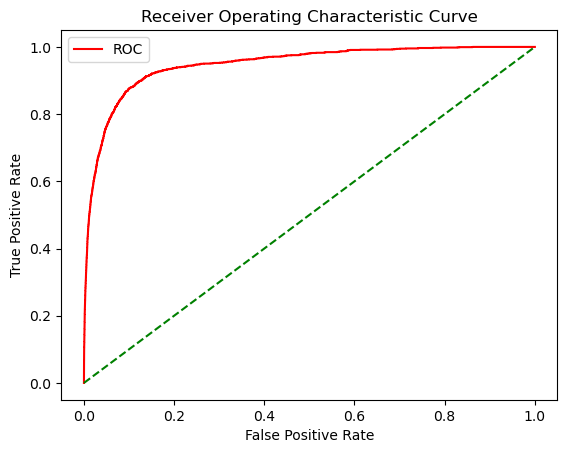

Feature importances(특성 중요도)
                 PC1: 43.4
                 PC2: 14.4
                 PC3: 3.4
                 PC4: 3.5
                 PC5: 14.9
                 PC6: 3.7
                 PC7: 4.7
                 PC8: 3.4
                 PC9: 2.0
                PC10: 1.3
                PC11: 2.7
                PC12: 1.6
                PC13: 1.1

pca_15모델 5-fold Cross Validation Accuracy(교차검증 정확도): 98.04
최적 하이퍼파라미터:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
TP : 96 , FN : 1456 , FP : 12
CSI 평가지표 : 0.06
Accuracy Score(정확도 점수): 0.98

Classification report(분류 보고서)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     63360
           1       0.89      0.06      0.12      1552

    accuracy                           0.98     64912
   macro avg       0.93      0.53      0.55     64912
weighted avg       0.98      0.98      0.97     64912


Confussion matrix(혼동행렬)
[[63348    12]

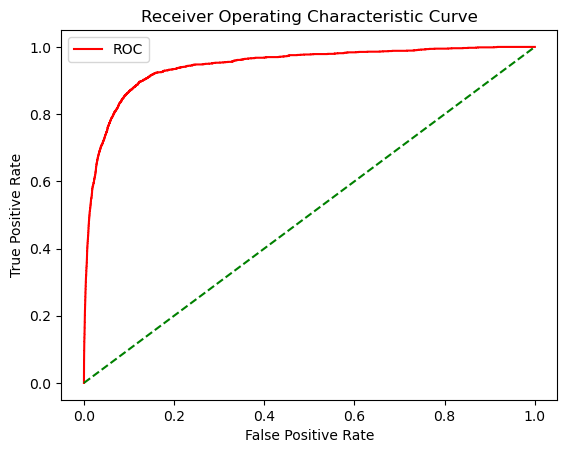

Feature importances(특성 중요도)
                 PC1: 37.2
                 PC2: 17.5
                 PC3: 4.1
                 PC4: 3.6
                 PC5: 14.6
                 PC6: 4.5
                 PC7: 4.7
                 PC8: 3.7
                 PC9: 1.8
                PC10: 1.2
                PC11: 2.1
                PC12: 1.7
                PC13: 1.1
                PC14: 1.1
                PC15: 1.0



In [166]:
# 주성분 개수 설정 리스트
n_components_list = [7, 10, 13, 15]

for n_components in n_components_list:
    pca_tr = globals()[f'pca_tr_{n_components}']
    pca_tst = globals()[f'pca_tst_{n_components}']
    pca_fi_evaluate_cl(ExtraTreesClassifier(), pca_tr, y_train, pca_tst, 'pca_' + str(n_components), k=5, test_size=0.3, feature_names=pca_tr.columns)

In [167]:
pca_df

,pca_7_ET,pca_10_ET,pca_13_ET,pca_15_ET
0,0,0,0,0
1,1,1,1,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
118810,0,0,0,0
118811,0,0,0,0
118812,0,0,0,0
118813,0,0,0,0


In [168]:
pca_df.to_csv('pca_df.csv')

In [237]:
pca_df['pca_15_ET'].value_counts()

0    118717
1        98
Name: pca_15_ET, dtype: int64

### 2-4. 이상치 제거

In [ ]:
final.loc[(final['distinction']=='N3')&(final['TARGET']==1)&(final['max_distance']>=1.5),'pca_13_ET'] = 0
final.loc[(final['distinction']=='N5')&(final['TARGET']==1)&(final['max_distance']>=1.5),'pca_13_ET'] = 0
final.loc[(final['distinction']=='N4')&(final['TARGET']==1)&(final['max_distance']>=1.5),'pca_13_ET'] = 0
final.loc[(final['distinction']=='N1')&(final['TARGET']==1)&(final['max_distance']>=1.5),'pca_13_ET'] = 0
final.loc[(final['distinction']=='N2')&(final['TARGET']==1)&(final['max_distance']>=1.5),'pca_13_ET'] = 0
final.loc[(final['distinction']=='M8-9')&(final['TARGET']==1)&(final['max_distance']>=1.5),'pca_13_ET'] = 0
final.loc[(final['distinction']=='M7')&(final['TARGET']==1)&(final['max_distance']>=1.5),'pca_13_ET'] = 0
final.loc[(final['distinction']=='E1')&(final['TARGET']==1)&(final['max_distance']>=1.5),'pca_13_ET'] = 0
final.loc[(final['distinction']=='E2')&(final['TARGET']==1)&(final['max_distance']>=1.5),'pca_13_ET'] = 0
final.loc[(final['distinction']=='E3')&(final['TARGET']==1)&(final['max_distance']>=1.5),'pca_13_ET'] = 0
final.loc[(final['distinction']=='M')&(final['TARGET']==1)&(final['max_distance']>=1.5),'pca_13_ET'] = 0

### 2-5. xlsx파일 불러와서 예측값 concat
#### 모델의 제일 괜찮은 예측결과를 xlsx파일에 추가하여 csv로 저장

In [138]:
oceanUser = pd.read_excel('oceanUser.xlsx')
oceanUser

,AREA,NUM,YEAR,MON,DAY,HOUR,MIN,TARGET
0,BUSAN,1001,2022,8,14,0,55,NaN
1,BUSAN,1001,2022,8,14,0,56,NaN
2,BUSAN,1001,2022,8,14,0,57,NaN
3,BUSAN,1001,2022,8,14,0,58,NaN
4,BUSAN,1001,2022,8,14,1,7,NaN
...,...,...,...,...,...,...,...,...
118810,ULSAN,1117,2023,1,17,19,44,NaN
118811,ULSAN,1117,2023,1,17,19,50,NaN
118812,ULSAN,1117,2023,1,17,19,56,NaN
118813,ULSAN,1117,2023,1,17,19,59,NaN


In [ ]:
pca_df

In [147]:
oceanUser['TARGET'] = pca_df['pca_15_ET']
model = 'pca_15_ET'

In [148]:
oceanUser

,AREA,NUM,YEAR,MON,DAY,HOUR,MIN,TARGET
0,BUSAN,1001,2022,8,14,0,55,0
1,BUSAN,1001,2022,8,14,0,56,0
2,BUSAN,1001,2022,8,14,0,57,0
3,BUSAN,1001,2022,8,14,0,58,0
4,BUSAN,1001,2022,8,14,1,7,0
...,...,...,...,...,...,...,...,...
118810,ULSAN,1117,2023,1,17,19,44,0
118811,ULSAN,1117,2023,1,17,19,50,0
118812,ULSAN,1117,2023,1,17,19,56,0
118813,ULSAN,1117,2023,1,17,19,59,0


In [149]:
oceanUser.to_csv('OUTPUT/'+model+'_FINAL_RESULT_'+now+'.csv', index=False) #oceanUser + 제일 괜찮은 모델 결과

In [150]:
pd.concat([bs_us_test1, pca_df],axis=1).to_csv('OUTPUT/CONCAT_RESULT_'+now+'.csv', index=False) #test data + models